# Evaluación modelos CO y FHMM

Vamos a poner a prueba los modelos de desagregación previamente entrenados en fases anteriores, para los cual deberiamos utilizar un conjunto de datos distinto al usado en el entrenamiento, con tal de aplicar las métricas provistas por NILMTK.

En primer lugar cargamos las ibrerías y realizamos otros ajustes:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='./data/'

## Set de Validación

Ahora tomamos una franja  horaria para validación  que no ha sido utilizada para entrenamiento  

In [2]:
#Set para validación
valid = DataSet('dsual.h5')
valid.set_window(start="2022-11-07 11:25:00", end="2022-11-07 11:35:00")
valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6,7,8,9,10,11])
print(valid_Devices)

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='DSUAL', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='electric furnace', instance=1)])
  ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='kettle', instance=1)])
  ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='electric space heater', instance=1)])
  ElecMeter(instance=8, building=1, dataset='DSUAL', appliances=[Appliance(type='electric shower heater', instance=1)])
  ElecMeter(instance=9, buildin

Ahora marcamos con etiquetas a todos los medidores

In [3]:
#labels = pd.DataFrame({'Instances': list(range(1,7)),
#                       'Meters': ['main',  'fan', 'freezer', 'television','vacuum cleaner', 'boiler']})
#print ("** Etiquetas ***")






#elec = deps.buildings[1].elec
labels = pd.DataFrame({'Instances': list(range(1,12)),
                       'Meters': ['Main', 'Electric furnace', 'Microwave','Television','Kettle','Vacuum cleaner','Electric space heater','Electric shower heater','Fan','Fridge','Freezer']})

print ("** Etiquetas ***")



print (labels)

Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]

** Etiquetas ***
    Instances                  Meters
0           1                    Main
1           2        Electric furnace
2           3               Microwave
3           4              Television
4           5                  Kettle
5           6          Vacuum cleaner
6           7   Electric space heater
7           8  Electric shower heater
8           9                     Fan
9          10                  Fridge
10         11                 Freezer


Y ahora vamos a representarlos datos de la validación para el contador principal

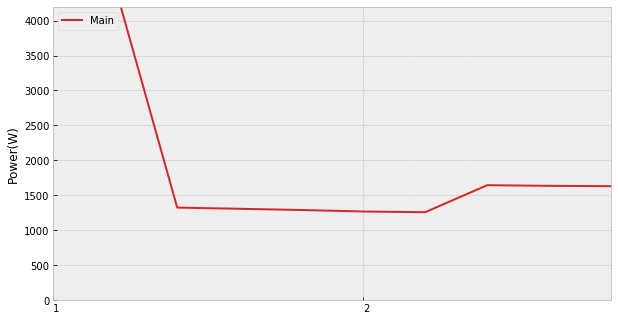

In [4]:
rcParams['figure.figsize'] = (10, 6)

t0='2022-11-07 11:25:00+01:00'
t1='2022-11-07 11:30:00+01:00'
t2='2022-11-07 12:05:00+01:00'

ax1 = next(valid_Main.load(ac_type='active', sample_period=60, resample_kwargs={'how':'first'}))[t0:t2].plot(c='tab:red') 
ax1.legend(['Main'], loc='upper left') #etiquetas
ax1.minorticks_off()
ax1.set(xticks=(t0, t1))
ax1.set_xticklabels(labels=['1','2'], ha='left', rotation=0)    
ax1.set_ylabel('Power(W)')
ax1.set_ylim(0,4200)
plt.savefig('./data/images/5.1_Plot_valid_main.svg', bbox_inches='tight', transparent=True)
pass

Asimismo tambien podemos ver el agregado de los diferentes contadores.

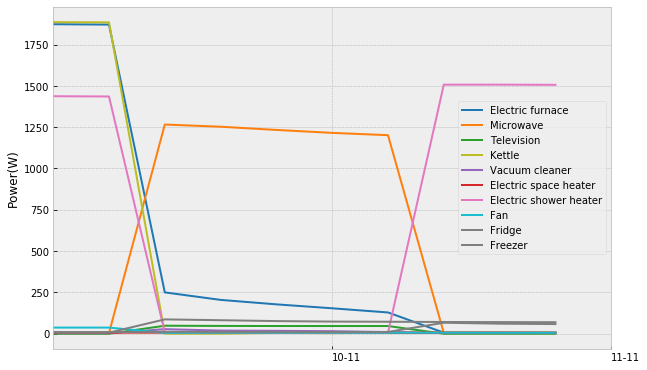

In [5]:
rcParams['figure.figsize'] = (10, 7)

t0='2022-11-07 10:25:00+01:00'
t1='2022-11-07 11:30:00+01:00'
t2='2022-11-07 11:35:00+01:00'

ax2 = valid_Devices.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})[t0:t2].plot()  
#colores
colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:red','tab:pink','tab:cyan','tab:gray','tab:grey']
c=0
for col in colors:    
    ax2.get_lines()[c].set_color(col)
    c=c+1   
ax2.legend(list(Meters.values())[1:11])
ax2.minorticks_off()
ax2.set(xticks=(t1, t2))
ax2.set_xticklabels(labels=['10-11','11-11'], ha='left', rotation=0)    
ax2.set_ylabel('Power(W)')
plt.savefig('./data/images/5.2_Plot_valid_devices.svg', bbox_inches='tight', transparent=True)
pass

### Desagregación para validación

La desagregación de los datos de validación se realiza utilizando los datos del MeterGroup valid_Main, el cual contiene el ElecMeter de los datos agregados del sistema eléctrico. Así, el medidor principal  será el dato de entrada para cada uno de los modelos de desagregación entrenados.


Veamos la degregacion  usando difrentes periodos de sampleo , difrentes metodos  y dos de los algoritmos mas tipicos como es el algoritmo combinatorio (CO) y el de las cadenas de Markovv (FHMM)

In [6]:
train = DataSet('dsual.h5')

train.set_window(start="2022-11-07 10:25:00", end="2022-11-07 11:25:00")
train_elec = train.buildings[1].elec

#Dispositivos para entrenamiento
train_Devices = train_elec.select(instance=[2,3,4,5,6,7,8,9,10,11])
train_Devices

from nilmtk.legacy.disaggregate import CombinatorialOptimisation, FHMM


#periods = {'1s':1, '10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}
periods = { '10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10}


methods = ['mean', 'median','first']

#solo si tarda mucho en ejecutarse
#periods = {'5s':5}
#methods = ['mean']

dir_models = './data/NILM/Models/'
times = {} #almacena tiempos de ejecución
null= {} #diccionario nulo
    
for sp_name, sp in periods.items():
    t = []
    
    for method in methods:
        models={'CO':CombinatorialOptimisation(), 'FHMM':FHMM()}

        for model_name, model in models.items():
            
            print("*"*20 + ' ' + model_name + ' ' + sp_name+ ' ' + method + "*"*20)
            #Entrenamiento
            model.MIN_CHUNK_LENGTH = 1
            import time
            start = time.time()
            model.train(train_Devices,
                        num_states_dict={ }, #diccionario de estados nulo, por defecto
                        ac_type='active', #potencia activa, por defecto
                        sample_period=sp, #cambio de muestreo
                        resample_kwargs={'how':method}) #método

            t.append(round(time.time()-start,2)) #tiempo de simulación

            #guarda modelo en formato h5           
            model_dir=data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5'
            output=HDFDataStore(model_dir, 'w')
            print ('Fichero del modelo:',model_dir)
            print (time.time())
            
            model.disaggregate(valid_Main, output, sample_period=sp, resample_kwargs={'how':method}, ac_type='active')
            output.close()
            
            #fichaje de los tiempos consumidos
            #end = time.time()-start
            #t.append(round(end,2))
            #print ('Tiempos de proceso:',t)
            
    times[sp_name] = t #tiempo de simulación
   
    
#ValueError: Shape of passed values is (4, 8), indices imply (6, 8)    
times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean', 'CO_median', 'FHMM_median','CO_first', 'FHMM_first'])

#times_v = pd.DataFrame(times,index=['CO_mean', 'FHMM_mean'])
    
    
print('\n\nDone!')


#tarda 62 minutos en recorrer hasta los 10minutos

******************** CO 10s mean********************
Training model for submeter 'ElecMeter(instance=2, building=1, dataset='DSUAL', appliances=[Appliance(type='electric furnace', instance=1)])'
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='DSUAL', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='DSUAL', appliances=[Appliance(type='television', instance=1)])'
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='DSUAL', appliances=[Appliance(type='kettle', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='DSUAL', appliances=[Appliance(type='vacuum cleaner', instance=1)])'
Training model for submeter 'ElecMeter(instance=7, building=1, dataset='DSUAL', appliances=[Appliance(type='electric space heater', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='DSUAL', appliances=[Appliance(type='electri

MemoryError: Unable to allocate 26.0 GiB for an array with shape (387420489, 9) and data type float64

In [ ]:
times_v.transpose()

### Comparacion de resultados

## metodo  mean

## 10 seg

Utilizaremos dos archivos de resultados (CO y FHMM 10s - mean) para visualizar las predicciones hechas por los modelos y contrastarlas con las mediciones reales de dispositivos en cada caso.

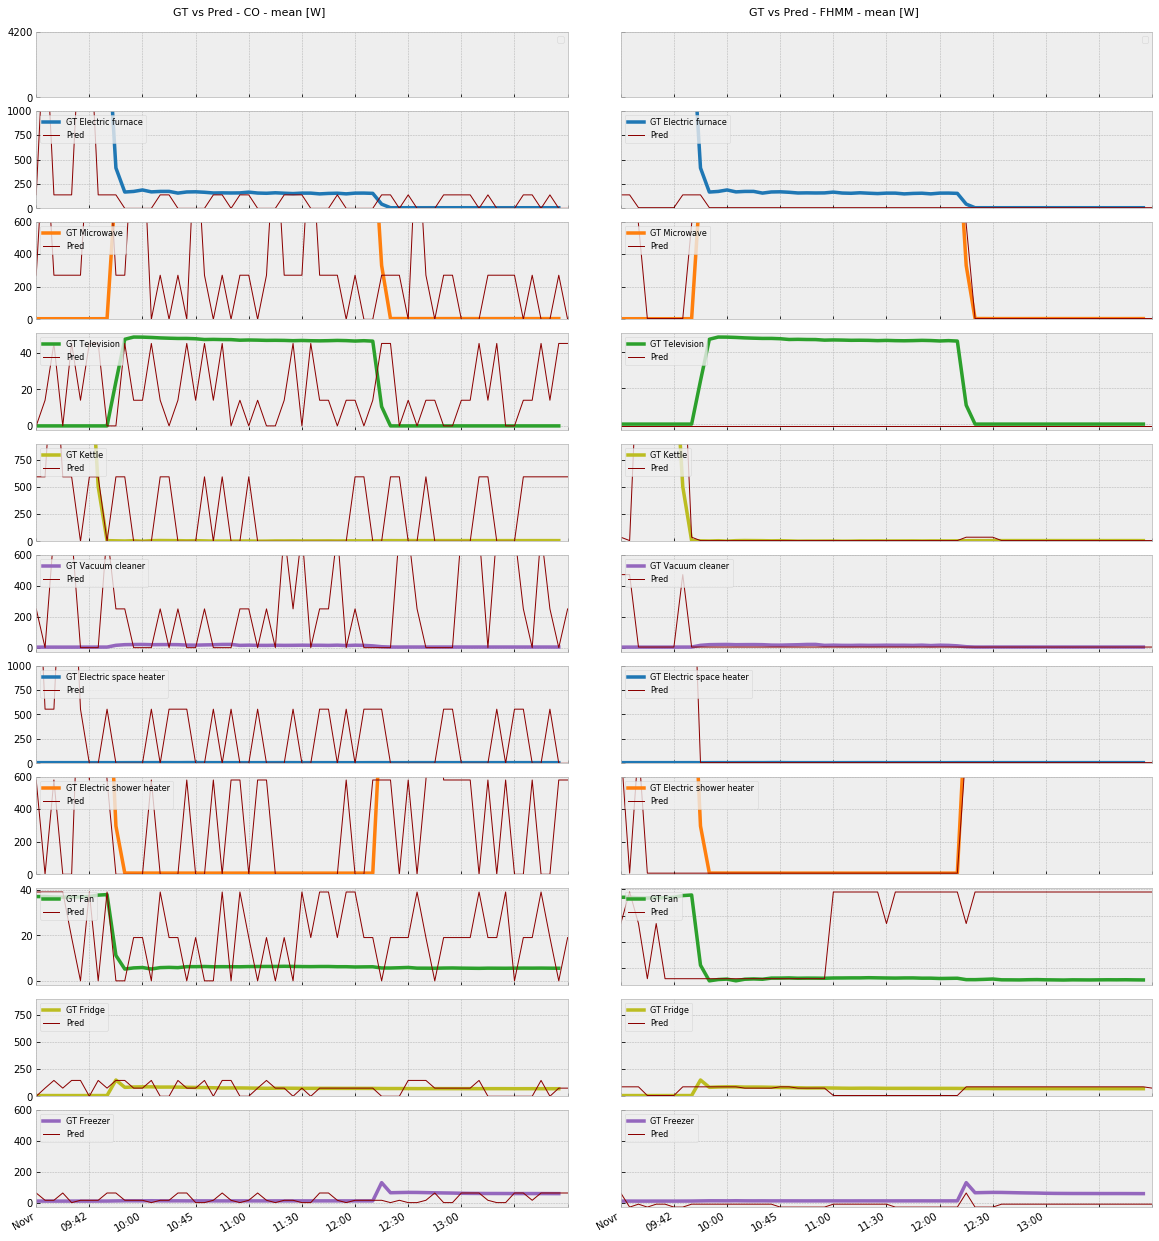

In [7]:
#resultados de predicción modelo CO 10s
CO_60s_first=DataSet(data_dir+'NILM/Results/CO_10s_mean_pred.h5')
elec_CO_60s_first=CO_60s_first.buildings[1].elec
#resultados de predicción modelo FHMM 10s
FHMM_60s_first=DataSet(data_dir+'NILM/Results/FHMM_10s_mean_pred.h5')
elec_FHMM_60s_first= FHMM_60s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=10, resample_kwargs={'how':'mean'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_60s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_60s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]


#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      





for i in range(2):
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - mean [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - mean [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_10s.svg', bbox_inches='tight', transparent=True)
pass

## 30 segundos

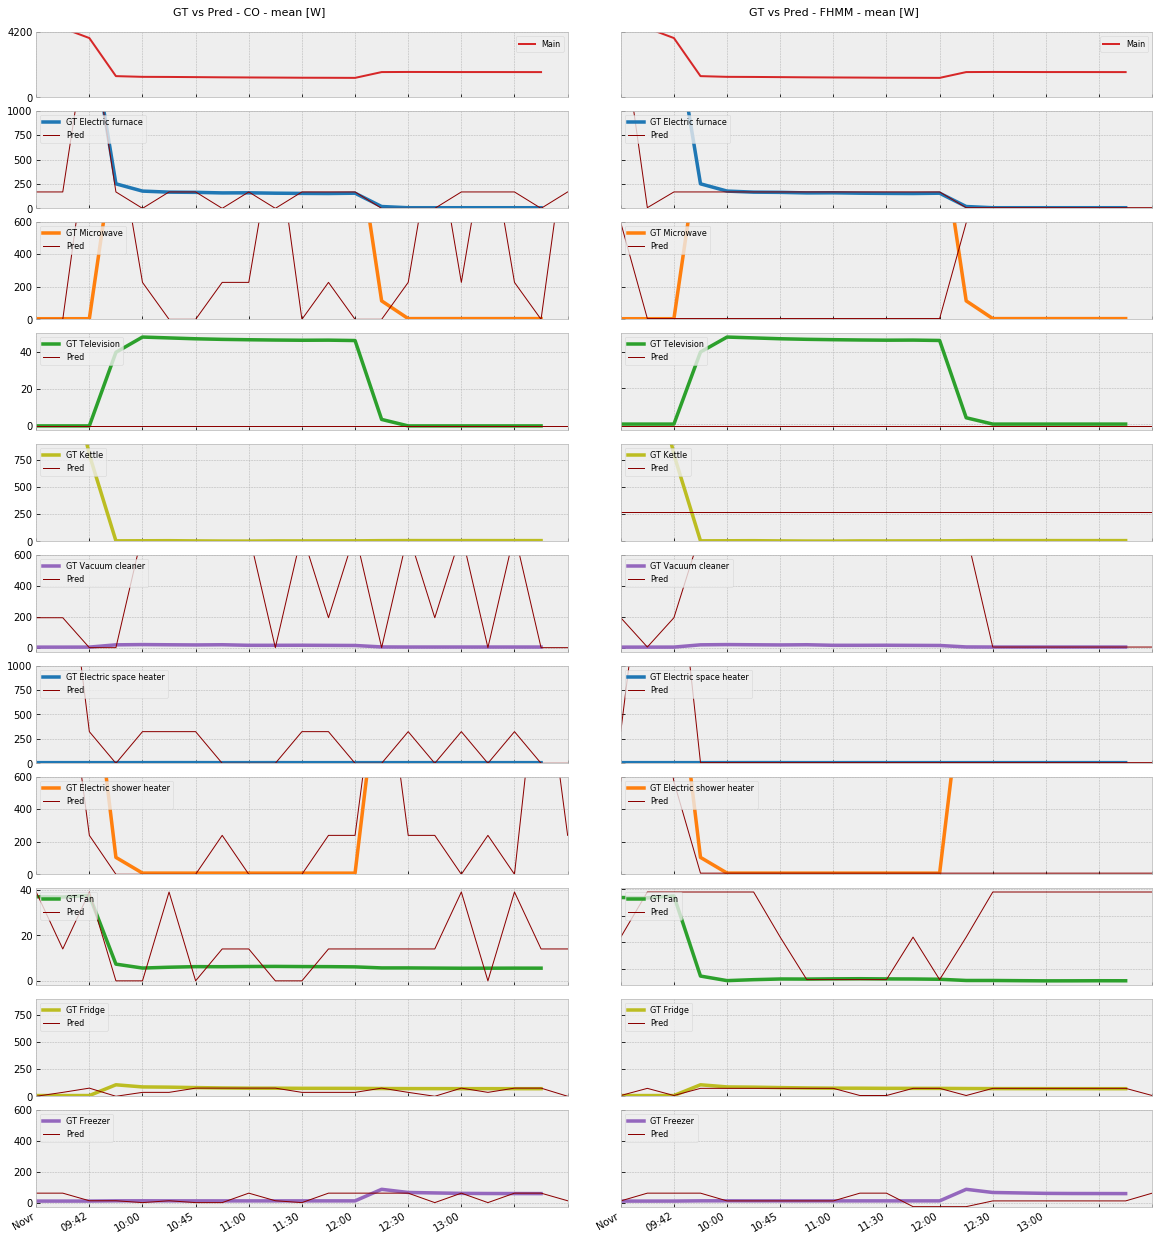

In [8]:
#resultados de predicción modelo CO 30s
CO_60s_first=DataSet(data_dir+'NILM/Results/CO_30s_mean_pred.h5')
elec_CO_60s_first=CO_60s_first.buildings[1].elec
#resultados de predicción modelo FHMM 30s
FHMM_60s_first=DataSet(data_dir+'NILM/Results/FHMM_30s_mean_pred.h5')
elec_FHMM_60s_first= FHMM_60s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=30, resample_kwargs={'how':'mean'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_60s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_60s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1, 'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})

t='60s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]

      
#labels = pd.DataFrame({'Instances': list(range(1,12)),
#                       'Meters': ['Main', 'Electric furnace', 'Microwave','Television','Kettle','Vacuum cleaner',
#             'Electric space heater','Electric shower heater','Fan','Fridge','Freezer']})
#                                                  
      
for i in range(2):
    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])       

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - mean [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - mean [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_30s.svg', bbox_inches='tight', transparent=True)
pass

## 1 min

Utilizaremos dos archivos de resultados (CO y FHMM 60s - mean) para visualizar las predicciones hechas por los modelos y contrastarlas con las mediciones reales de dispositivos en cada caso.

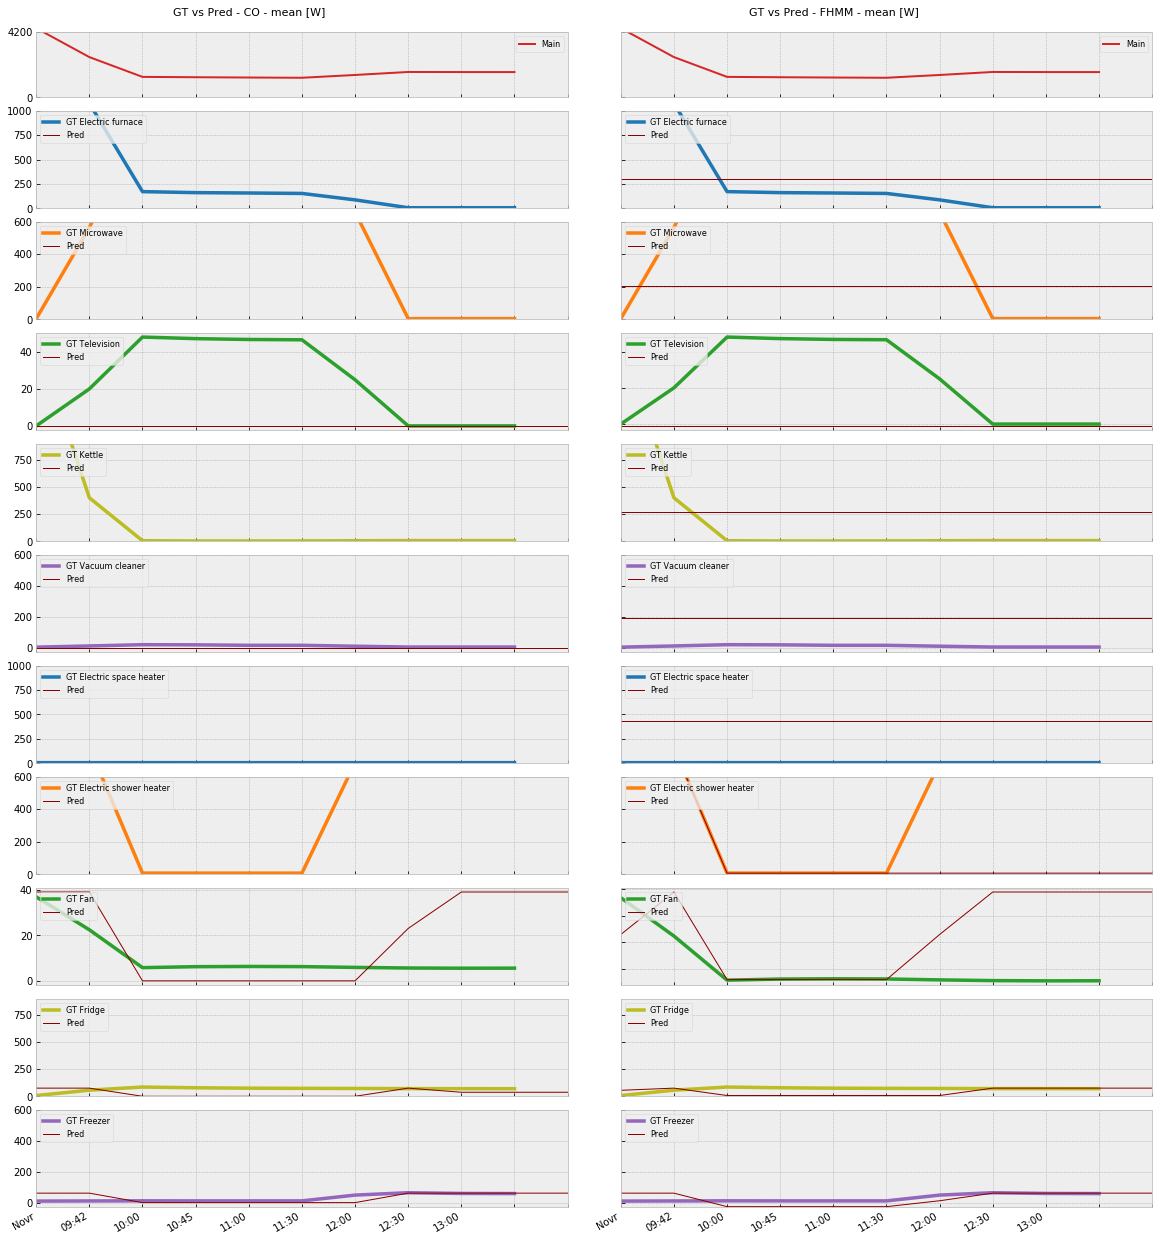

In [9]:
#resultados de predicción modelo CO 60s
CO_30s_first=DataSet(data_dir+'NILM/Results/CO_60s_mean_pred.h5')
elec_CO_30s_first=CO_30s_first.buildings[1].elec

#resultados de predicción modelo FHMM 30s
FHMM_30s_first=DataSet(data_dir+'NILM/Results/FHMM_60s_mean_pred.h5')
elec_FHMM_30s_first= FHMM_30s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'mean'})
gt.columns=list(Meters.values())
pred_CO=elec_CO_30s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_30s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='30s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
      

for i in range(2):

    gt['Main'].plot(ax=ax[i][0], color='tab:red',legend=False)
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])       
     

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - mean [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - mean [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_60s.svg', bbox_inches='tight', transparent=True)
pass

## 5 min

Utilizaremos dos archivos de resultados (CO y FHMM 5min - mean) para visualizar las predicciones hechas por los modelos y contrastarlas con las mediciones reales de dispositivos en cada caso.

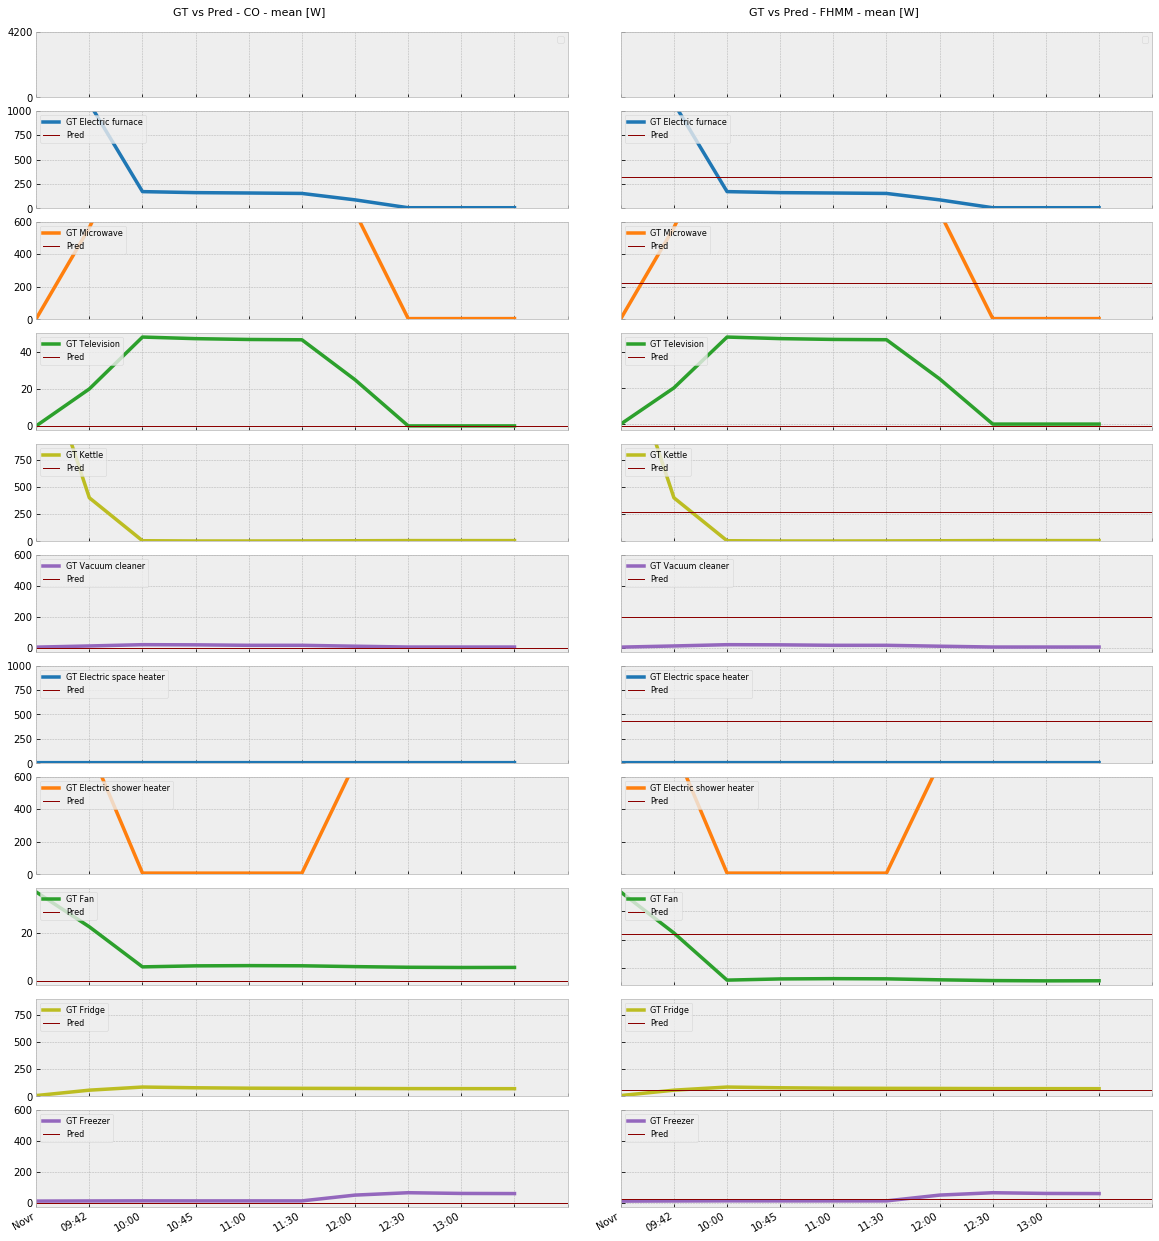

In [10]:
#resultados de predicción modelo CO 5min
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_5min_mean_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec
#resultados de predicción modelo FHMM 1s
FHMM_1s_first=DataSet(data_dir+'NILM/Results/FHMM_5min_mean_pred.h5')
elec_FHMM_1s_first= FHMM_1s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'mean'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_1s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]
pred_FHMM=elec_FHMM_1s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]




#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      





for i in range(2):
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - mean [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - mean [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_5min.svg', bbox_inches='tight', transparent=True)
pass

## 10 min

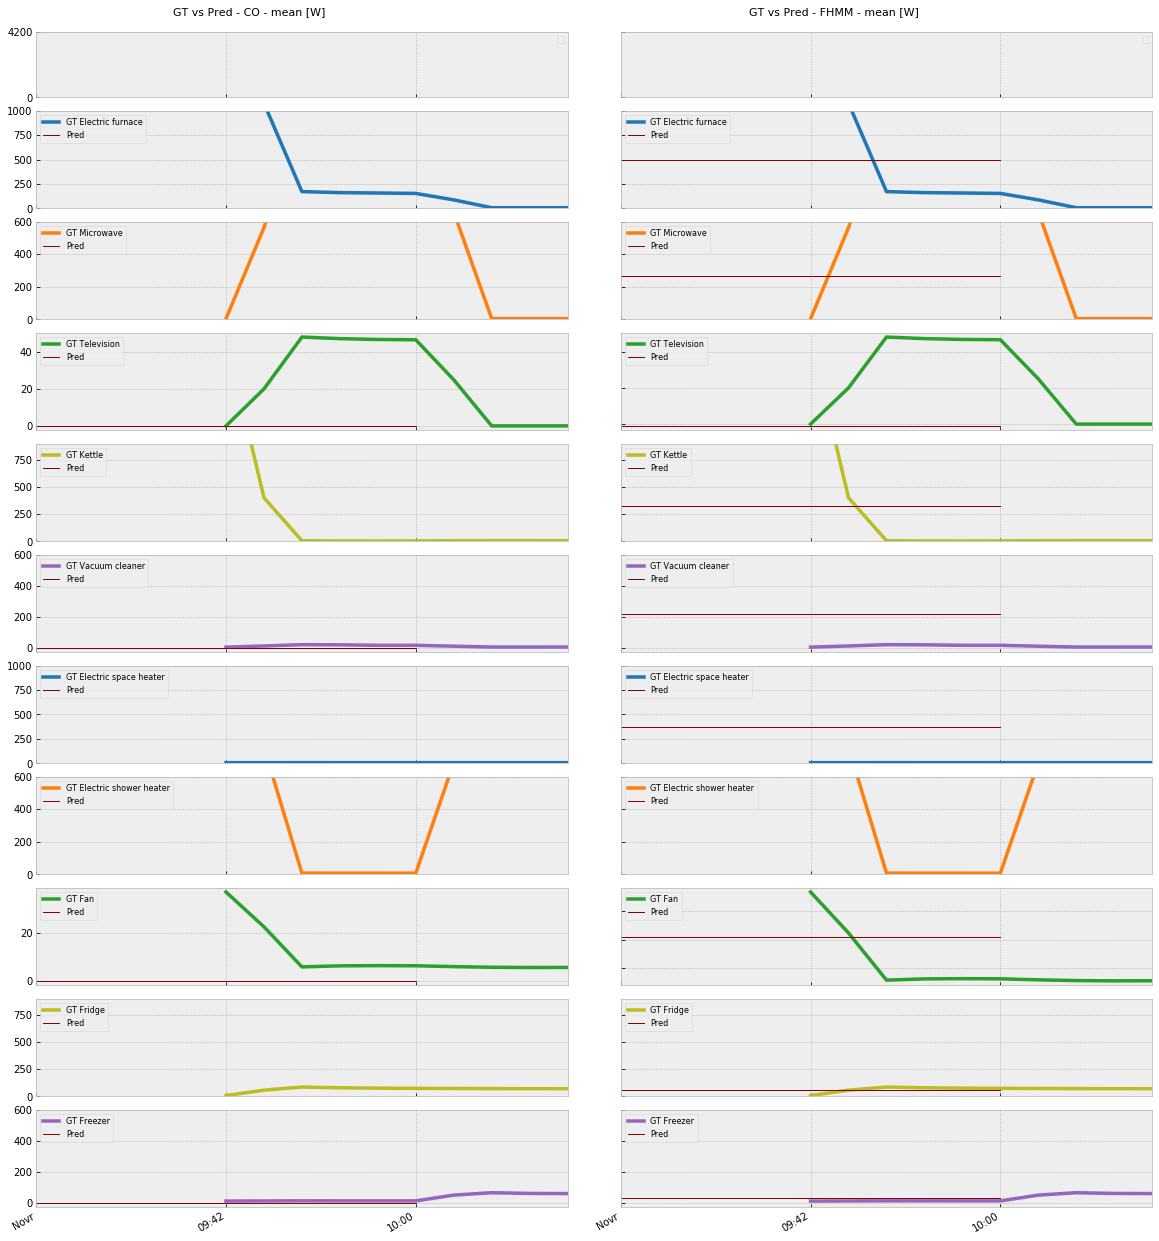

In [11]:
#resultados de predicción modelo CO 10min
CO_10m_first=DataSet(data_dir+'NILM/Results/CO_10min_mean_pred.h5')
elec_CO_10m_first=CO_10m_first.buildings[1].elec
#resultados de predicción modelo FHMM 10min
FHMM_10m_first=DataSet(data_dir+'NILM/Results/FHMM_10min_mean_pred.h5')
elec_FHMM_10m_first= FHMM_10m_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'mean'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_10m_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]
pred_FHMM=elec_FHMM_10m_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]




#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      





for i in range(2):
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - mean [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - mean [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_10min.svg', bbox_inches='tight', transparent=True)
pass

## metodo median

## 10 segundos

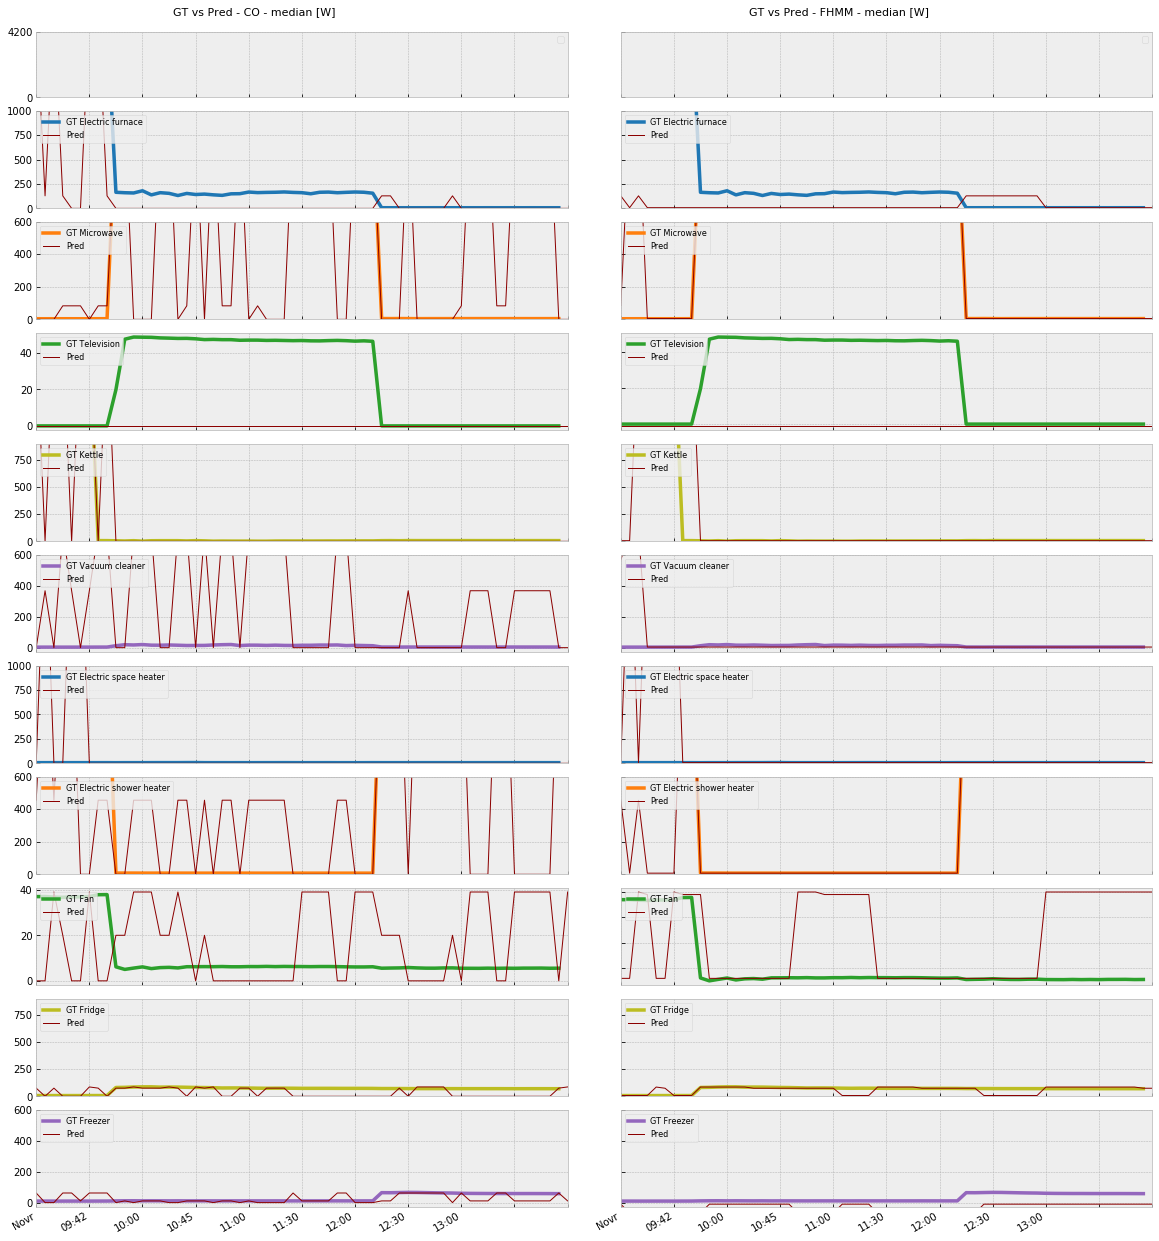

In [12]:
#resultados de predicción modelo CO 10s
CO_60s_first=DataSet(data_dir+'NILM/Results/CO_10s_median_pred.h5')
elec_CO_60s_first=CO_60s_first.buildings[1].elec
#resultados de predicción modelo FHMM 10s
FHMM_60s_first=DataSet(data_dir+'NILM/Results/FHMM_10s_median_pred.h5')
elec_FHMM_60s_first= FHMM_60s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=10, resample_kwargs={'how':'median'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_60s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_60s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]




#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='61s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]

for i in range(2):
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    
    
for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - median [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - median [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_10s.svg', bbox_inches='tight', transparent=True)
pass

## 30 segundos

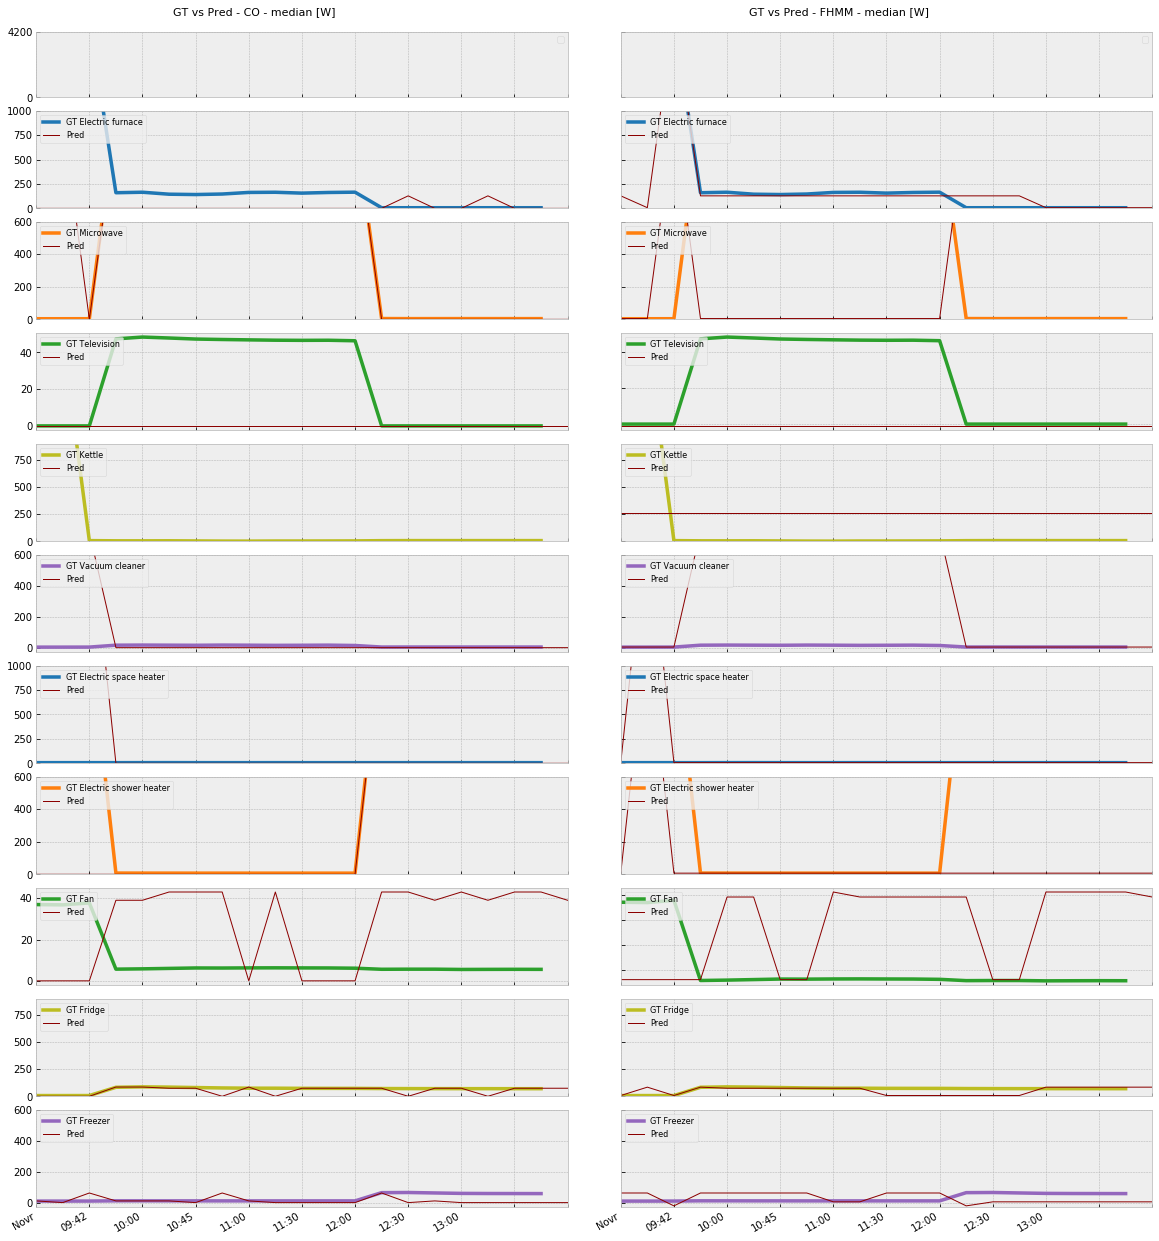

In [13]:
#resultados de predicción modelo CO 30s
CO_30s_first=DataSet(data_dir+'NILM/Results/CO_30s_median_pred.h5')
elec_CO_30s_first=CO_30s_first.buildings[1].elec
#resultados de predicción modelo FHMM 30s
FHMM_30s_first=DataSet(data_dir+'NILM/Results/FHMM_30s_median_pred.h5')
elec_FHMM_30s_first= FHMM_30s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=30, resample_kwargs={'how':'median'})
gt.columns=list(Meters.values())
pred_CO=elec_CO_30s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_30s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]




#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='30s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]

for i in range(2):

    
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - median [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - median [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_30s.svg', bbox_inches='tight', transparent=True)
pass

## 60 segundos

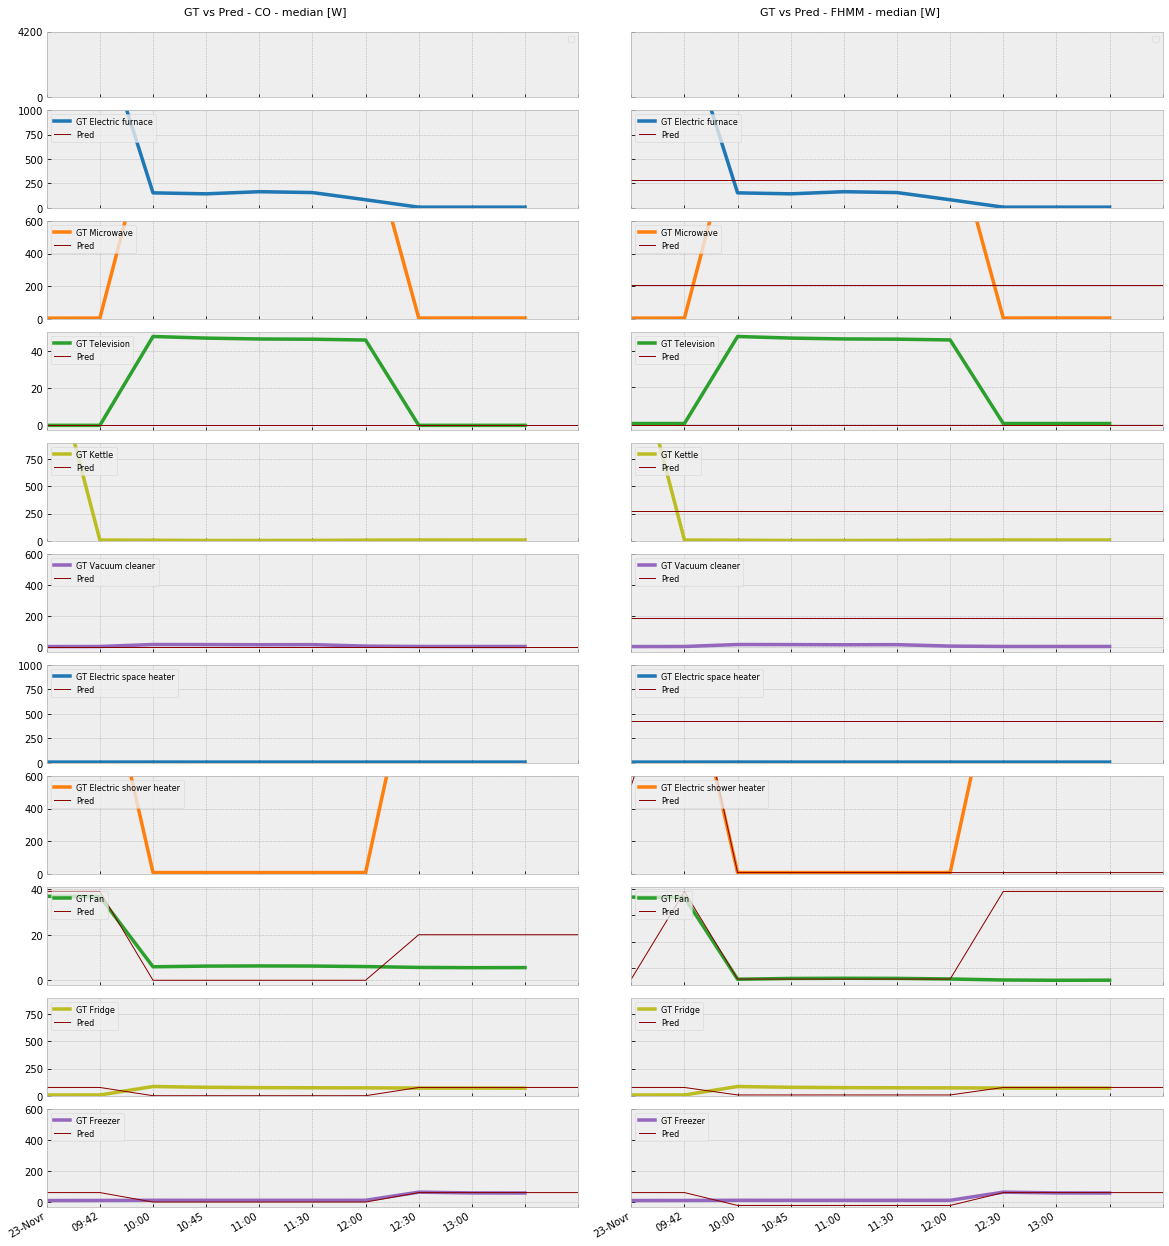

In [14]:
#resultados de predicción modelo CO 60s
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_60s_median_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec
#resultados de predicción modelo FHMM 60s
FHMM_1s_first=DataSet(data_dir+'NILM/Results/FHMM_60s_median_pred.h5')
elec_FHMM_1s_first= FHMM_1s_first.buildings[1].elec
#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'median'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_1s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]
pred_FHMM=elec_FHMM_1s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      



for i in range(2):
   
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['23-Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - median [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - median [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_60s.svg', bbox_inches='tight', transparent=True)
pass

## 5 min

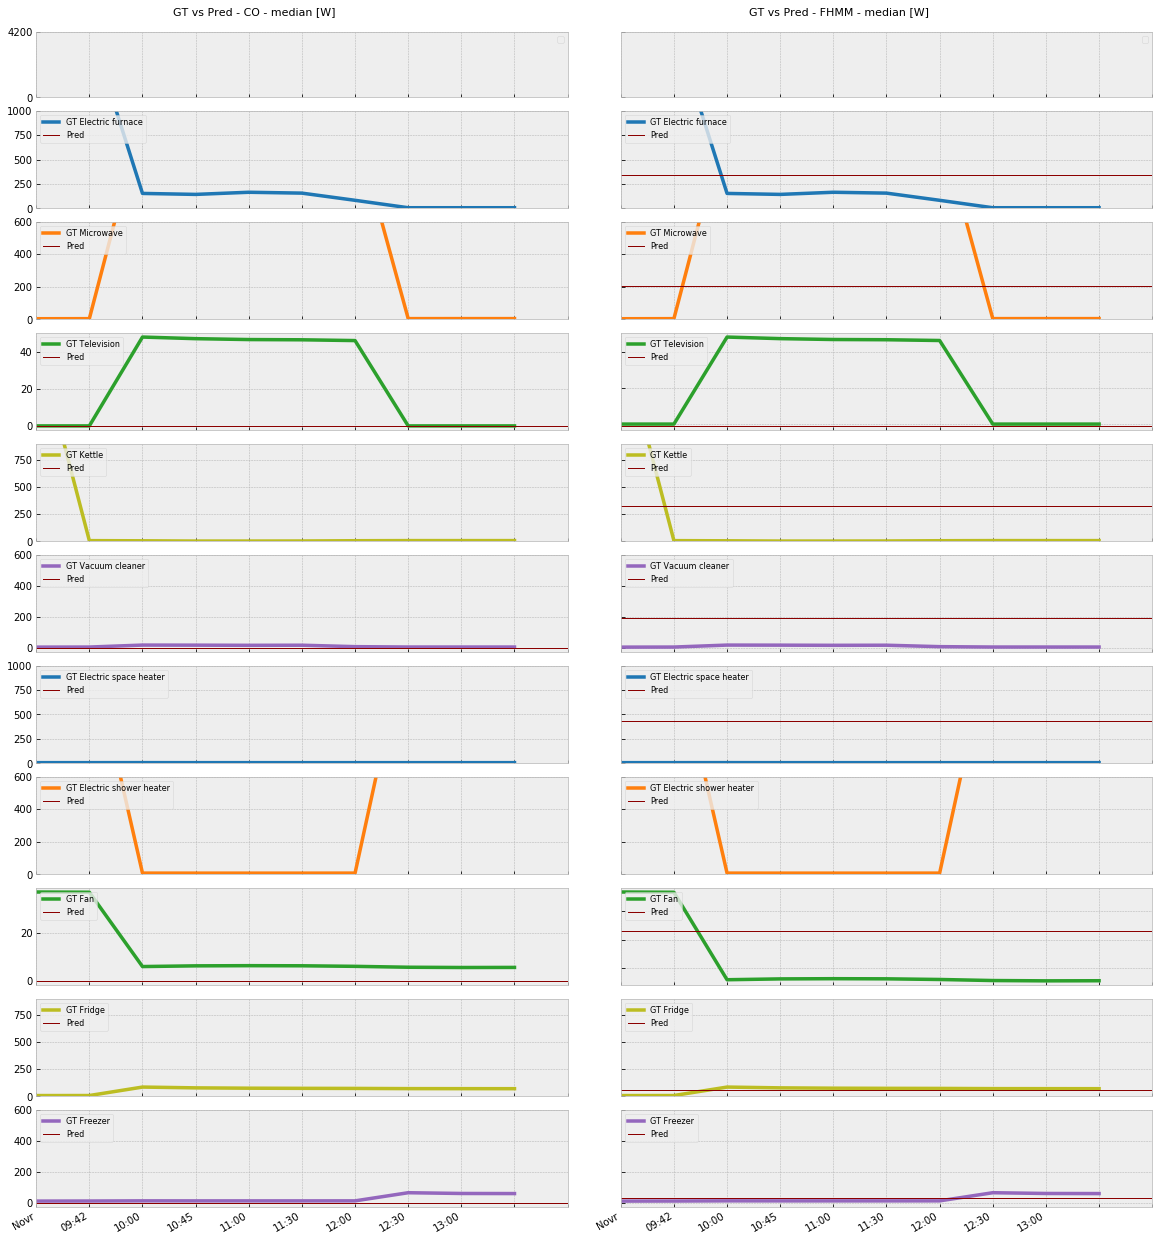

In [15]:
#resultados de predicción modelo CO 300s
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_5min_median_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec
#resultados de predicción modelo FHMM 300s
FHMM_1s_first=DataSet(data_dir+'NILM/Results/FHMM_5min_median_pred.h5')
elec_FHMM_1s_first= FHMM_1s_first.buildings[1].elec
#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'median'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_1s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]
pred_FHMM=elec_FHMM_1s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      



for i in range(2):
   
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - median [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - median [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_300s.svg', bbox_inches='tight', transparent=True)
pass

## 10 min

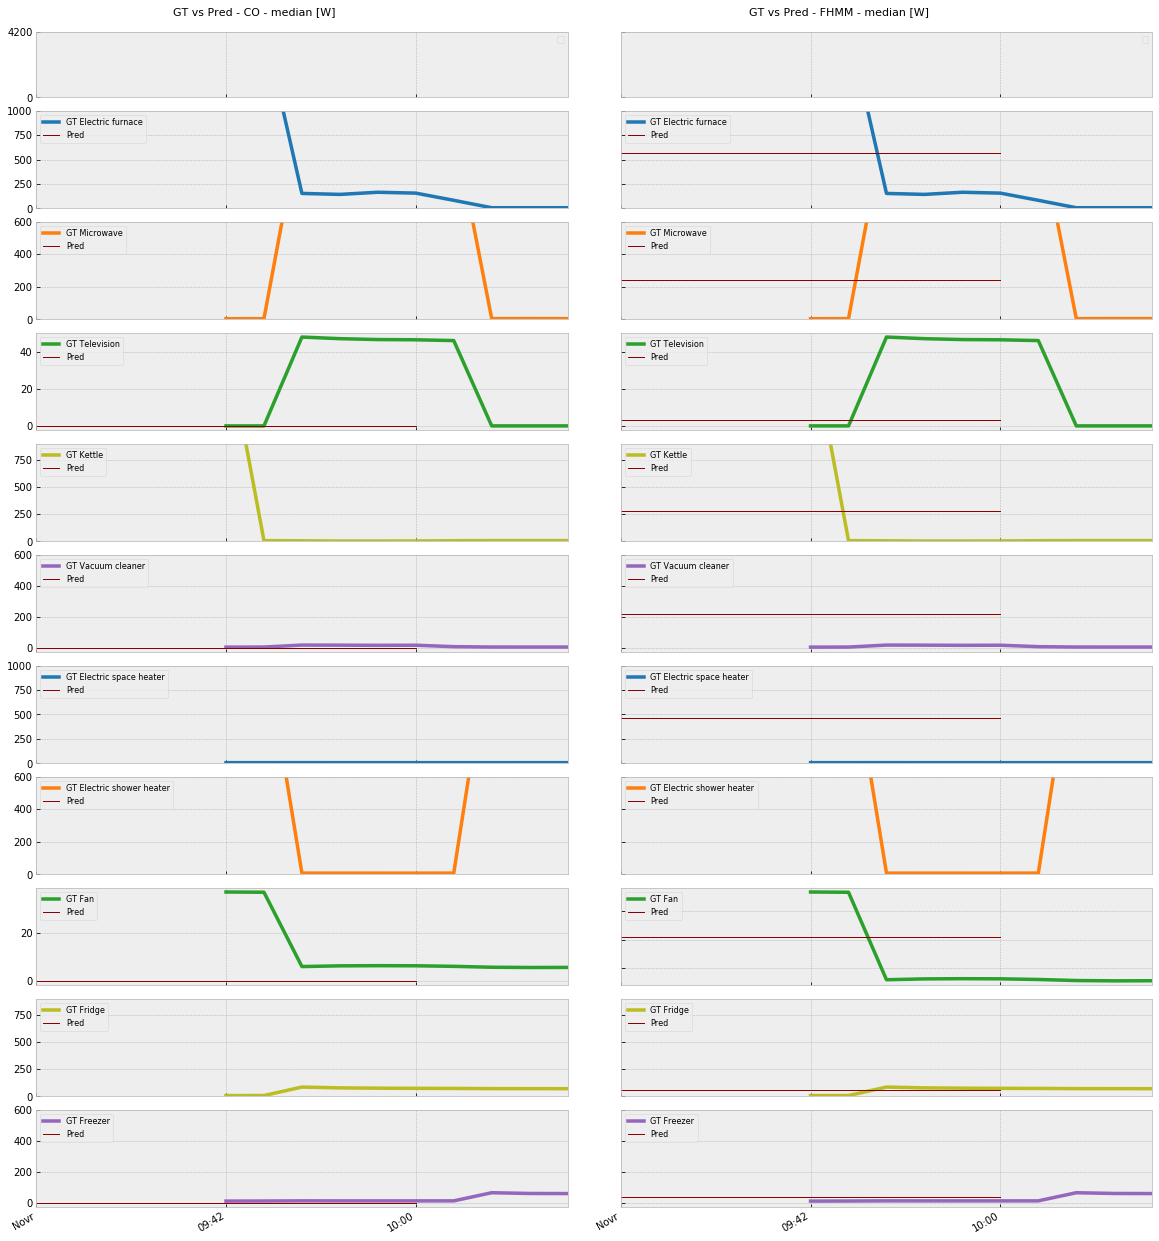

In [16]:
#resultados de predicción modelo CO 600s
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_10min_median_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec
#resultados de predicción modelo FHMM 600s
FHMM_1s_first=DataSet(data_dir+'NILM/Results/FHMM_10min_median_pred.h5')
elec_FHMM_1s_first= FHMM_1s_first.buildings[1].elec
#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'median'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_1s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]
pred_FHMM=elec_FHMM_1s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      



for i in range(2):
   
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - median [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - median [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_600s.svg', bbox_inches='tight', transparent=True)
pass

## metodo first

## 10 seg

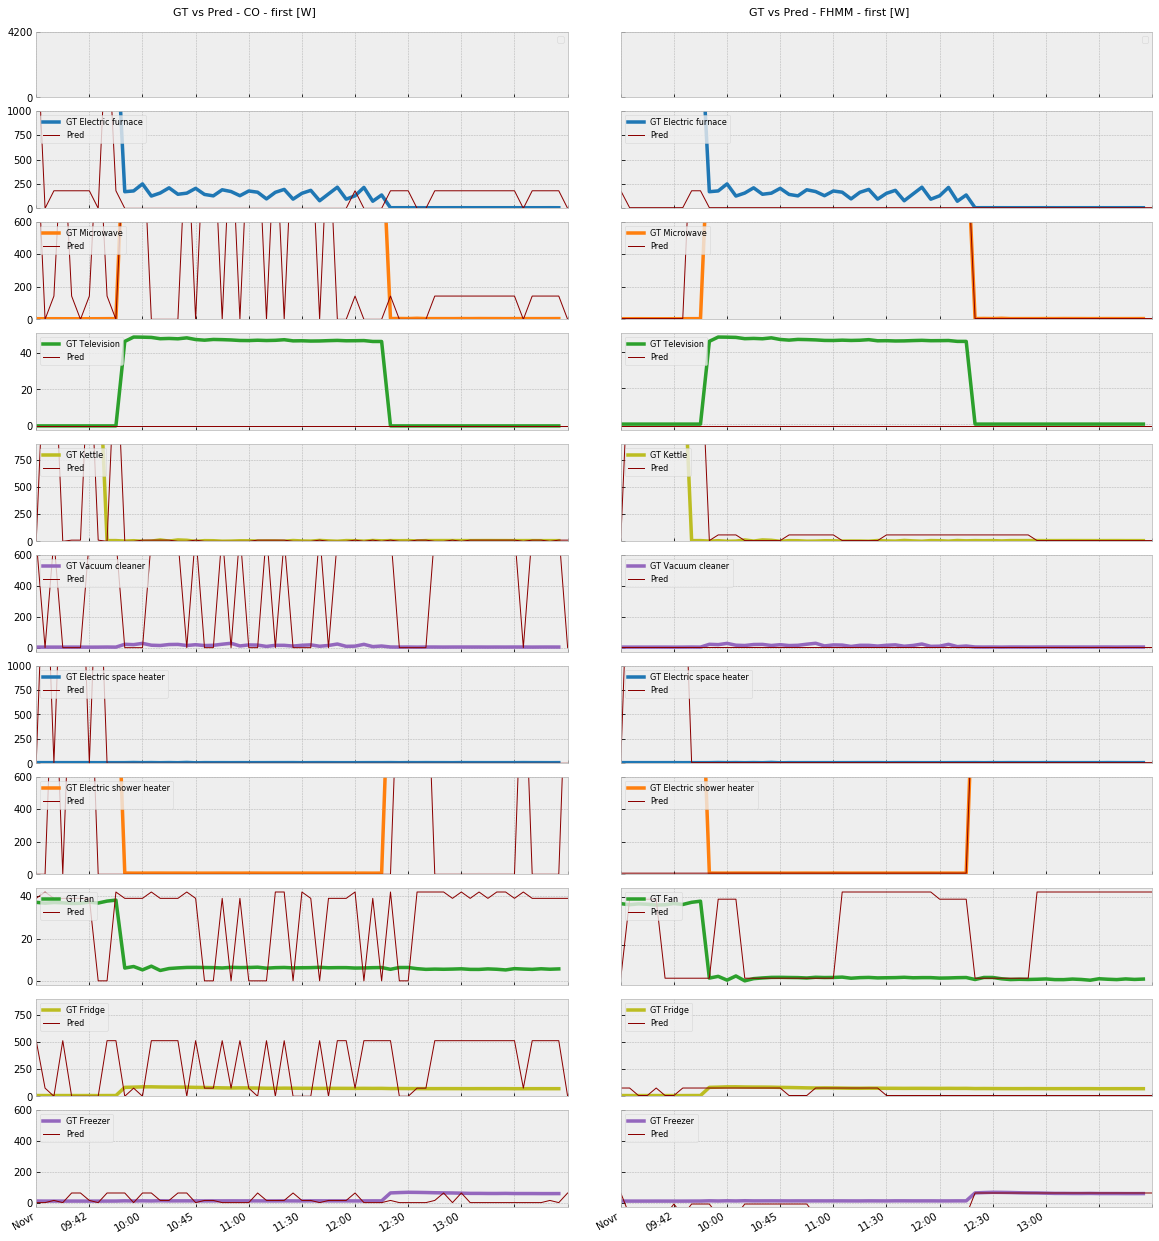

In [17]:
#resultados de predicción modelo CO 60s
CO_60s_first=DataSet(data_dir+'NILM/Results/CO_10s_first_pred.h5')
elec_CO_60s_first=CO_60s_first.buildings[1].elec
#resultados de predicción modelo FHMM 60s
FHMM_60s_first=DataSet(data_dir+'NILM/Results/FHMM_10s_first_pred.h5')
elec_FHMM_60s_first= FHMM_60s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=10, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_60s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_60s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]




#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='60s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      

      
      

for i in range(2):
    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    
    
for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_10s.svg', bbox_inches='tight', transparent=True)
pass

## 30 seg

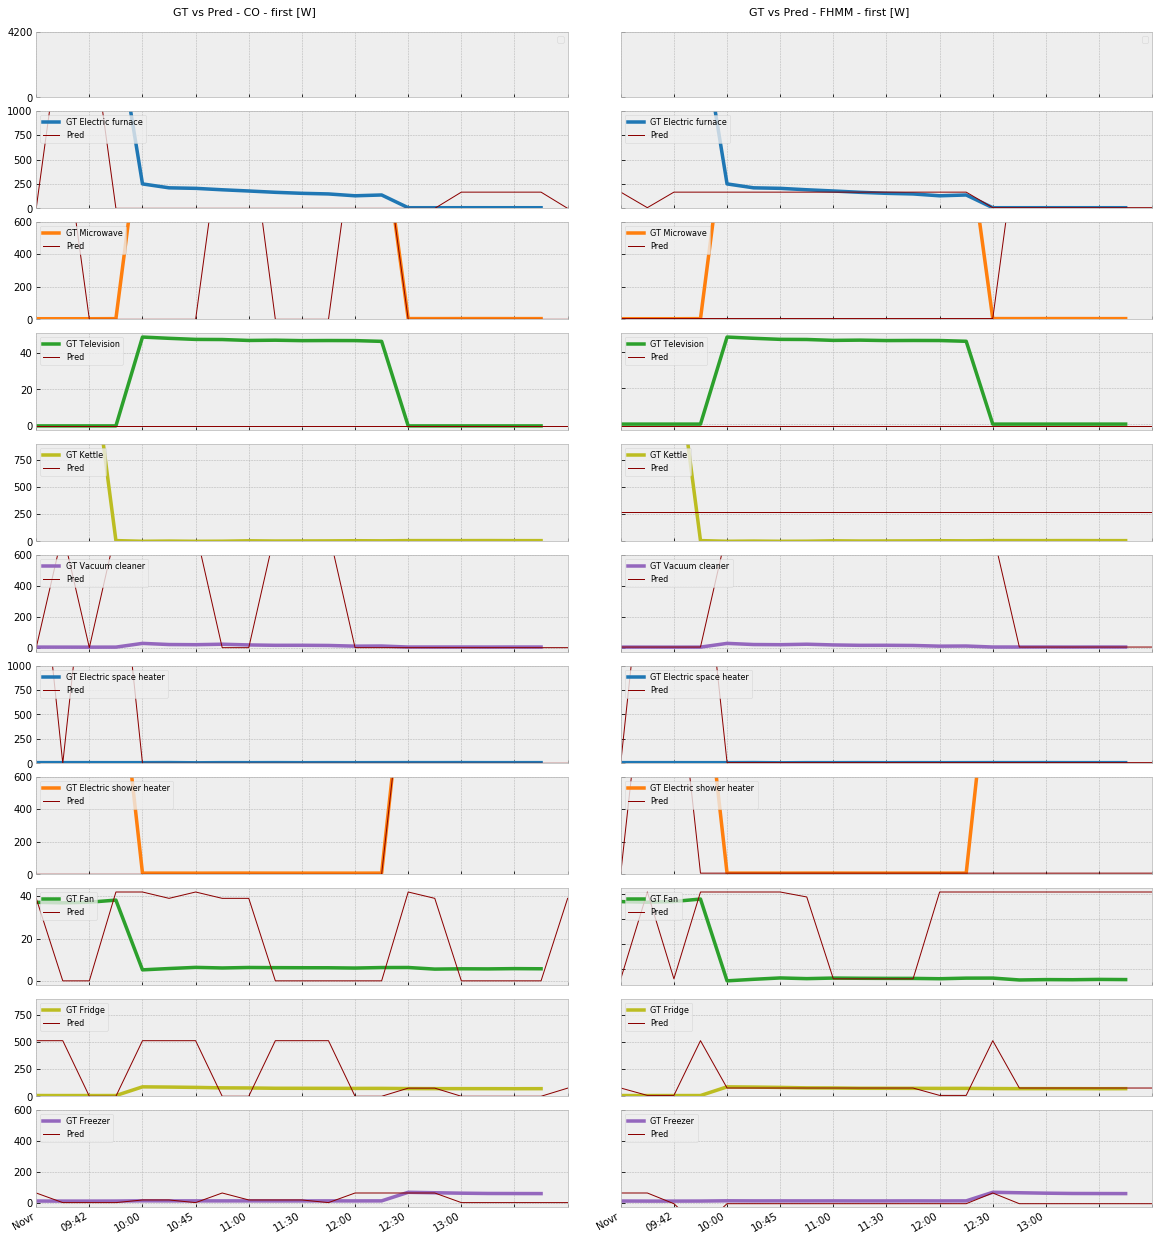

In [18]:
#resultados de predicción modelo CO 30s
CO_30s_first=DataSet(data_dir+'NILM/Results/CO_30s_first_pred.h5')
elec_CO_30s_first=CO_30s_first.buildings[1].elec
#resultados de predicción modelo FHMM 30s
FHMM_30s_first=DataSet(data_dir+'NILM/Results/FHMM_30s_first_pred.h5')
elec_FHMM_30s_first= FHMM_30s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=30, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())
pred_CO=elec_CO_30s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_30s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]




#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='30s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      
      

for i in range(2):

    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    
    
    
for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_30s.svg', bbox_inches='tight', transparent=True)
pass

## 1 minutos

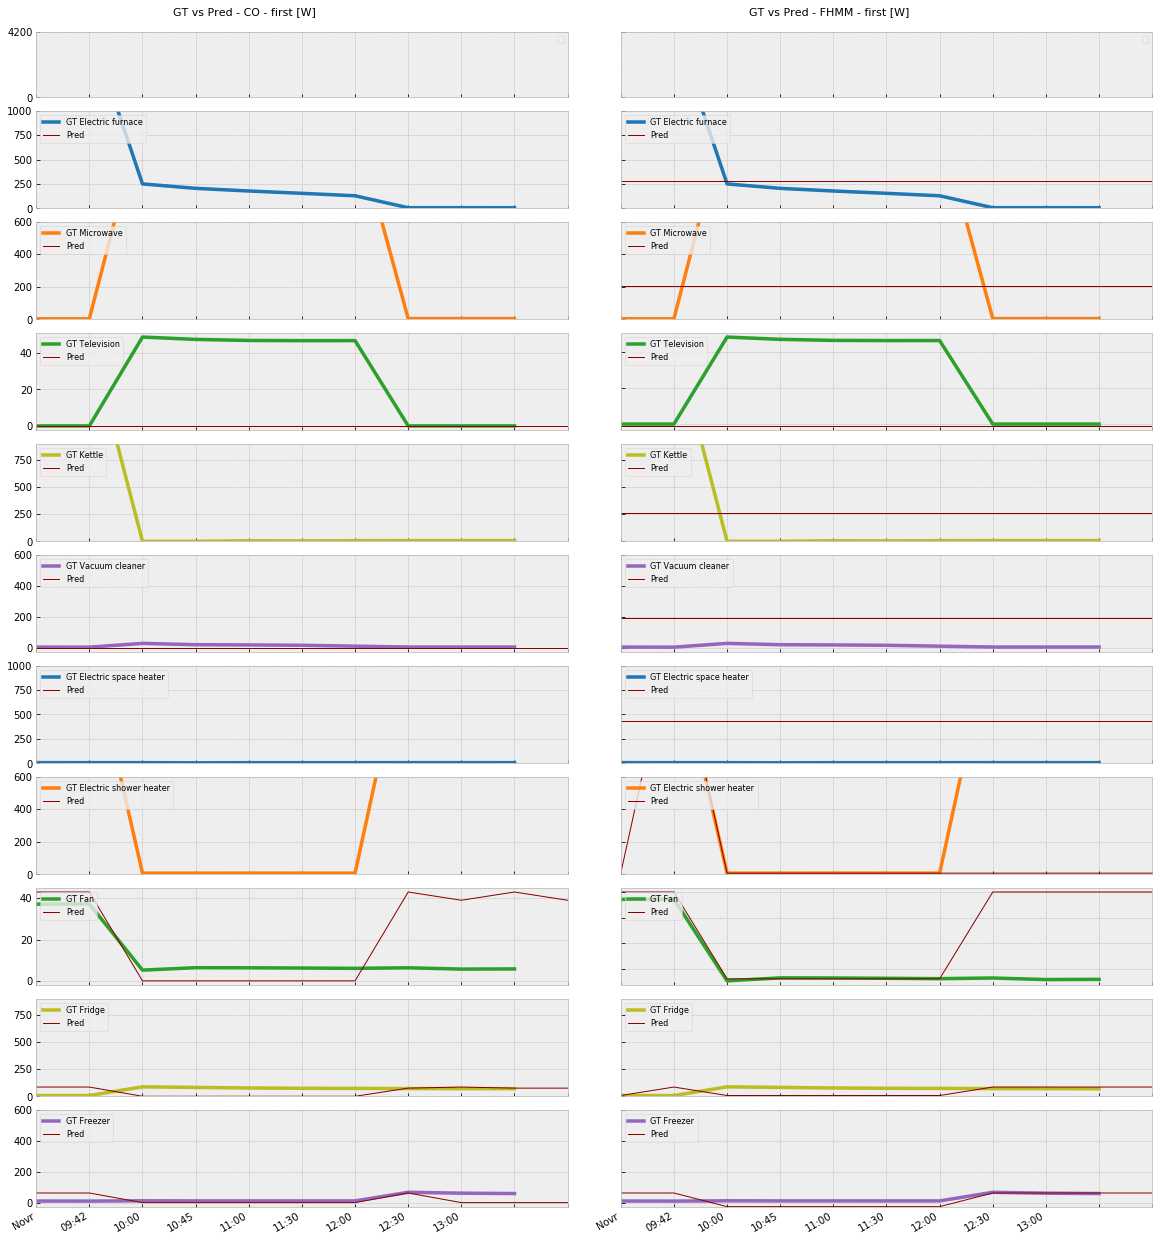

In [19]:
#resultados de predicción modelo CO 30s
CO_30s_first=DataSet(data_dir+'NILM/Results/CO_60s_first_pred.h5')
elec_CO_30s_first=CO_30s_first.buildings[1].elec
#resultados de predicción modelo FHMM 30s
FHMM_30s_first=DataSet(data_dir+'NILM/Results/FHMM_60s_first_pred.h5')
elec_FHMM_30s_first= FHMM_30s_first.buildings[1].elec

#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())
pred_CO=elec_CO_30s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]

pred_FHMM=elec_FHMM_30s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]




#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='30s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 
      
      

for i in range(2):

    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    
    
    
for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_60s.svg', bbox_inches='tight', transparent=True)
pass

## 5 minutos

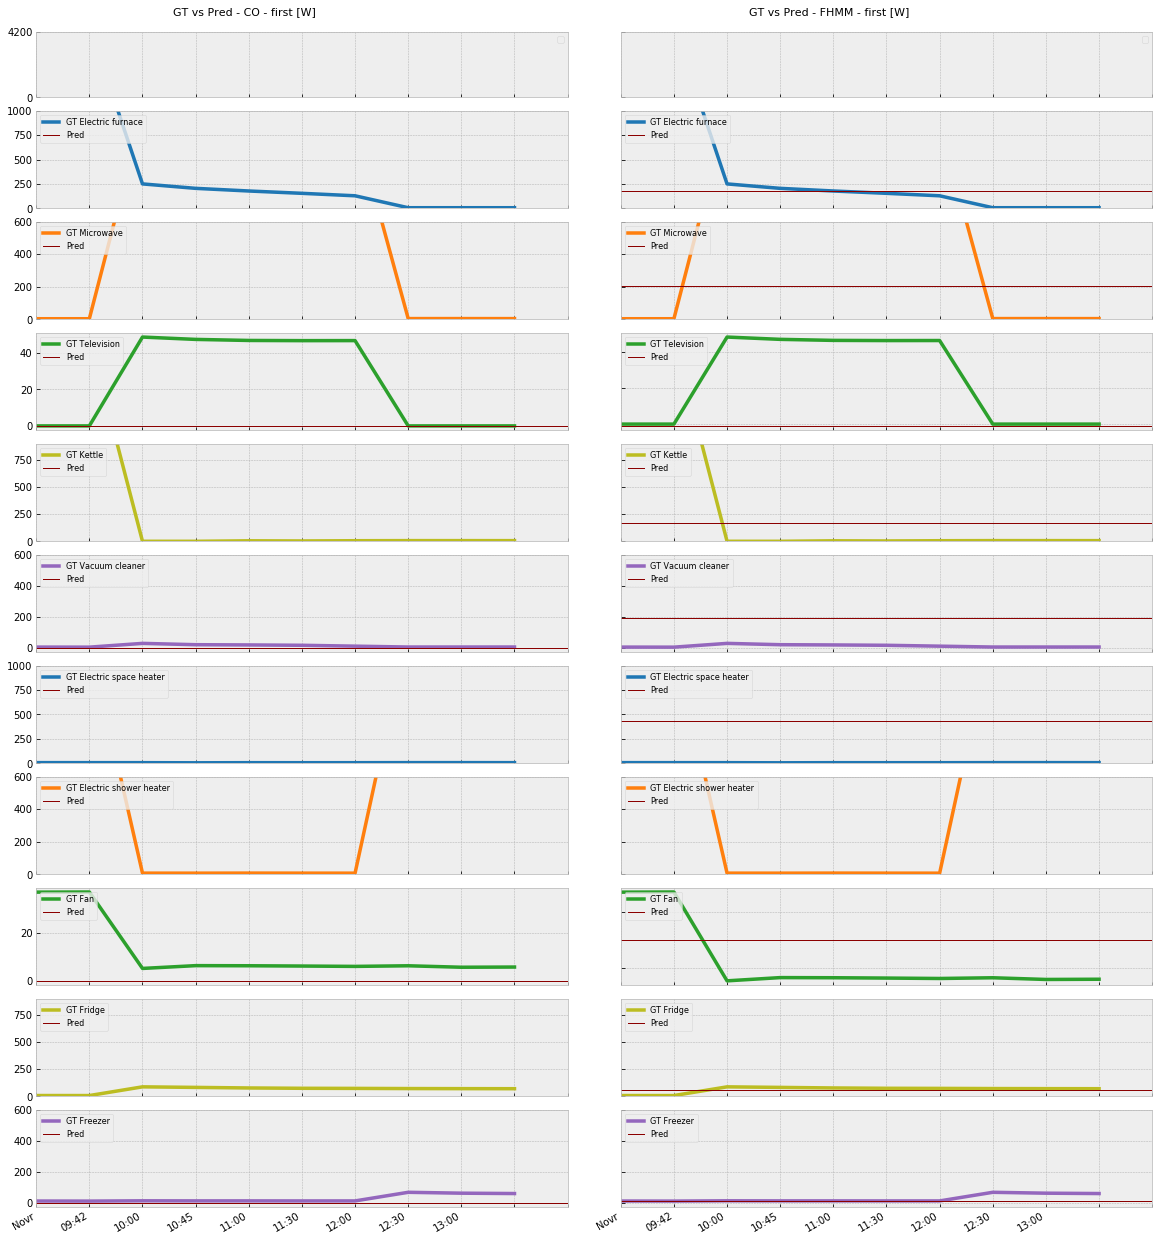

In [20]:
#resultados de predicción modelo CO 1s
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_5min_first_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec
#resultados de predicción modelo FHMM 1s
FHMM_1s_first=DataSet(data_dir+'NILM/Results/FHMM_5min_first_pred.h5')
elec_FHMM_1s_first= FHMM_1s_first.buildings[1].elec
#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_1s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]
pred_FHMM=elec_FHMM_1s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 






for i in range(2):
   


    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_300s.svg', bbox_inches='tight', transparent=True)
pass

## 10 min

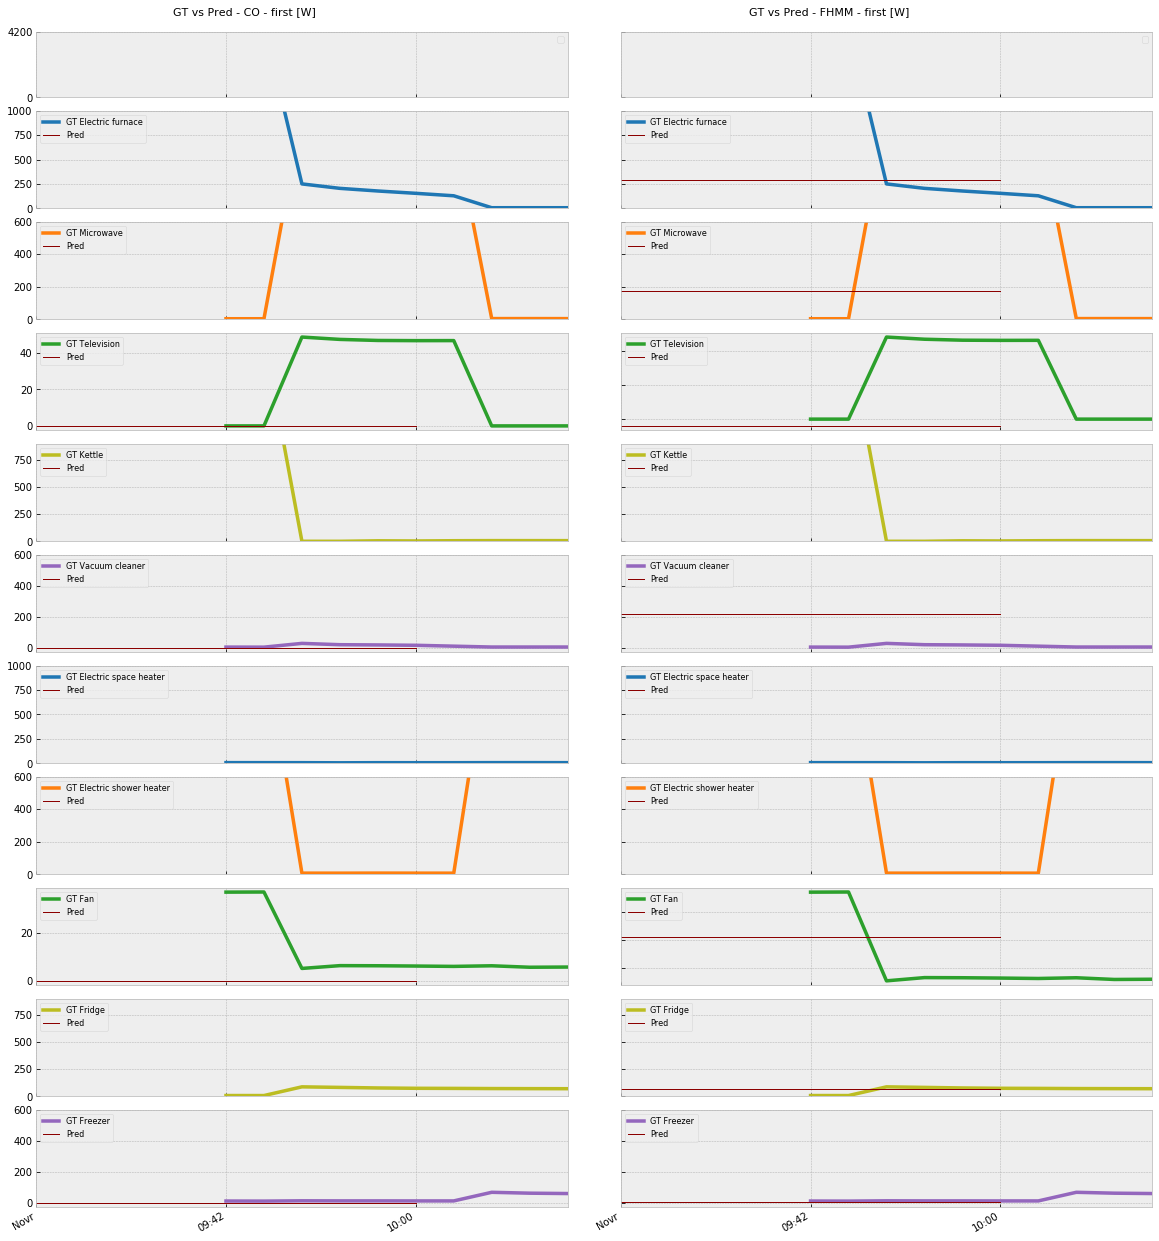

In [21]:
#resultados de predicción modelo CO 10min
CO_1s_first=DataSet(data_dir+'NILM/Results/CO_10min_first_pred.h5')
elec_CO_1s_first=CO_1s_first.buildings[1].elec
#resultados de predicción modelo FHMM 10min
FHMM_1s_first=DataSet(data_dir+'NILM/Results/FHMM_10min_first_pred.h5')
elec_FHMM_1s_first= FHMM_1s_first.buildings[1].elec
#Carga de datos de predicciones y GT en memoria
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
gt.columns=list(Meters.values())

pred_CO=elec_CO_1s_first.dataframe_of_meters(ac_type='active')
pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]
pred_FHMM=elec_FHMM_1s_first.dataframe_of_meters(ac_type='active')
pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:11]



#graficos
rcParams['figure.figsize'] = (20, 24)
fig, ((ax_a,ax_b),(ax1,ax12),(ax2,ax13),(ax3,ax14), (ax4,ax15),(ax5,ax16),(ax6,ax17),(ax7,ax18),(ax8,ax19), (ax9,ax20),(ax10,ax21)) = plt.subplots(11, 2, sharex=True, gridspec_kw={'hspace': 0.14,'wspace': 0.1,
                                                                                       'height_ratios':[2,3,3,3,3,3,3,3,3,3,3]})
t='1s'; m1='_CO'; m2='_FHMM'; f=8

pred=[pred_CO, pred_FHMM]
ax=[[ax_a,ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10],[ax_b,ax12,ax13,ax14,ax15,ax16,ax17,ax18,ax19,ax20,ax21]]
 






for i in range(2):
   


    ax[i][0].legend(labels=['Main'], fontsize=f, loc='best', ncol=1)
    ax[i][0].set_ylim(0,4200)
    ax[i][0].set(yticks=[0,4200]) 
    
    gt['Electric furnace'].plot(ax=ax[i][1],lw=3.5, c='tab:blue')
    pred[i]['Electric furnace'].plot(ax=ax[i][1], c='darkred', lw=1)
    ax[i][1].legend(labels=['GT Electric furnace','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][1].set_ylim(0,1000)
    
    gt['Microwave'].plot(ax=ax[i][2], lw=3.5, c='tab:orange')
    pred[i]['Microwave'].plot(ax=ax[i][2], c='darkred', lw=1)
    ax[i][2].legend(labels=['GT Microwave','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][2].set_ylim(0,600)

    gt['Television'].plot(ax=ax[i][3],lw=3.5, c='tab:green')
    pred[i]['Television'].plot(ax=ax[i][3], c='darkred', lw=1)
    ax[i][3].legend(labels=['GT Television','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Kettle'].plot(ax=ax[i][4], lw=3.5, c='tab:olive')
    pred[i]['Kettle'].plot(ax=ax[i][4], c='darkred', lw=1)
    ax[i][4].legend(labels=['GT Kettle','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][4].set_ylim(0,900)

    gt['Vacuum cleaner'].plot(ax=ax[i][5], lw=3.5, c='tab:purple')
    pred[i]['Vacuum cleaner'].plot(ax=ax[i][5], c='darkred', lw=1)
    ax[i][5].legend(labels=['GT Vacuum cleaner','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][5].set_ylim(-30,600)

#####
      
    gt['Electric space heater'].plot(ax=ax[i][6],lw=3.5, c='tab:blue')
    pred[i]['Electric space heater'].plot(ax=ax[i][6], c='darkred', lw=1)
    ax[i][6].legend(labels=['GT Electric space heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][6].set_ylim(0,1000)
    
    gt['Electric shower heater'].plot(ax=ax[i][7], lw=3.5, c='tab:orange')
    pred[i]['Electric shower heater'].plot(ax=ax[i][7], c='darkred', lw=1)
    ax[i][7].legend(labels=['GT Electric shower heater','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][7].set_ylim(0,600)

    gt['Fan'].plot(ax=ax[i][8],lw=3.5, c='tab:green')
    pred[i]['Fan'].plot(ax=ax[i][8], c='darkred', lw=1)
    ax[i][8].legend(labels=['GT Fan','Pred'], fontsize=f, loc='upper left', ncol=1)

    
    gt['Fridge'].plot(ax=ax[i][9], lw=3.5, c='tab:olive')
    pred[i]['Fridge'].plot(ax=ax[i][9], c='darkred', lw=1)
    ax[i][9].legend(labels=['GT Fridge','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][9].set_ylim(0,900)

    gt['Freezer'].plot(ax=ax[i][10], lw=3.5, c='tab:purple')
    pred[i]['Freezer'].plot(ax=ax[i][10], c='darkred', lw=1)
    ax[i][10].legend(labels=['GT Freezer','Pred'], fontsize=f, loc='upper left', ncol=1)
    ax[i][10].set_ylim(-30,600)
      
      
    ax[i][10].minorticks_off()
    ax[i][10].set_xticklabels(labels=['Novr','09:42','10:00','10:45','11:00','11:30','12:00','12:30','13:00'])  
    
    
    
    

for a in ax[1]: a.set_yticklabels([])
fig.text(0.22, 0.89,'GT vs Pred - CO - first [W]', fontsize=11)
fig.text(0.62, 0.89,'GT vs Pred - FHMM - first [W]', fontsize=11)
plt.savefig('./data/images/5.3_Plot_valid_600s.svg', bbox_inches='tight', transparent=True)
pass